# NLP Final Project - Spam Classification

#### data source: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

### Team 04

#### Members: Charlotte Ku, Jenny Choi, Zeeshan Raza

#### Intro: Here, we demonstrate a neural network that can identify whether a message is spam or not

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_text as text

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

/Users/rouhsin_charlotte/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
from google.colab import files
uploaded = files.upload()

Saving spam.xlsx to spam.xlsx


## Loading Data

In [2]:
df = pd.read_excel('spam.xlsx', index_col = False)

df.rename(columns={'v1': 'Category', 'v2': 'Message'}, inplace=True)
df.drop('Unnamed: 2', inplace=True, axis=1)
df.drop('Unnamed: 3', inplace=True, axis=1)
df.drop('Unnamed: 4', inplace=True, axis=1)

df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [4]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']

print("Ham Dataset Shape:", df_ham.shape)
print("Spam Dataset Shape:", df_spam.shape)

Ham Dataset Shape: (4825, 2)
Spam Dataset Shape: (747, 2)


## Preprocessing Data
### Balancing HAM and SPAM data

In [5]:
#will use df_spam.shape[0] - 747
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [42]:
df_balanced = pd.concat([df_spam , df_ham_downsampled])
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

### Labeling Data

In [43]:
# creating numerical repersentation of category - one hot encoding
df_balanced['spam'] = df['Category'].apply(lambda x:1 if x=='spam' else 0)
df_balanced

,Category,Message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1
...,...,...,...
1089,ham,Goodmorning today i am late for &lt;DECIMAL&g...,0
245,ham,Too late. I said i have the website. I didn't ...,0
2452,ham,Okay. I've seen it. So i should pick it on fri...,0
5099,ham,"Ah, well that confuses things, doesnt it? I th...",0


## Method 1: Encoding Data with BERT Model
### Test Train Split

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'],
                                                   stratify = df_balanced['spam'])

### Encoding data with BERT model

In [45]:
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [46]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

### Training model

In [47]:
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [48]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_word_ids':   0           ['Inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [49]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

In [50]:
model.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [51]:
history = model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
35/35 [==============================] - 514s 14s/step - loss: 0.6430 - accuracy: 0.6438 - precision: 0.6466 - recall: 0.6339
Epoch 2/10
35/35 [==============================] - 507s 14s/step - loss: 0.5213 - accuracy: 0.7911 - precision: 0.7985 - recall: 0.7786
Epoch 3/10
35/35 [==============================] - 503s 14s/step - loss: 0.4477 - accuracy: 0.8375 - precision: 0.8327 - recall: 0.8446
Epoch 4/10
35/35 [==============================] - 504s 14s/step - loss: 0.3958 - accuracy: 0.8679 - precision: 0.8552 - recall: 0.8857
Epoch 5/10
35/35 [==============================] - 502s 14s/step - loss: 0.3648 - accuracy: 0.8821 - precision: 0.8754 - recall: 0.8911
Epoch 6/10
35/35 [==============================] - 501s 14s/step - loss: 0.3391 - accuracy: 0.8777 - precision: 0.8678 - recall: 0.8911
Epoch 7/10
35/35 [==============================] - 501s 14s/step - loss: 0.3307 - accuracy: 0.8786 - precision: 0.8643 - recall: 0.8982
Epoch 8/10
35/35 [=======================

### Evaluating model

In [53]:
model.evaluate(X_test,y_test )

12/12 [==============================] - 171s 14s/step - loss: 0.2937 - accuracy: 0.9091 - precision: 0.9135 - recall: 0.9037


[0.2937468886375427, 0.9090909361839294, 0.9135135412216187, 0.903743326663971]

In [54]:
y_pred = model.predict(X_test)>0.5
y_pred = y_pred.flatten() 

12/12 [==============================] - 168s 14s/step


In [55]:
y_pred

array([False, False, False, False,  True, False,  True,  True, False,
        True, False, False, False,  True,  True,  True, False,  True,
       False, False,  True,  True, False, False, False, False,  True,
       False, False,  True, False,  True, False,  True,  True, False,
        True, False, False, False, False,  True, False, False,  True,
       False,  True,  True, False,  True, False, False,  True, False,
       False,  True,  True, False,  True, False, False, False,  True,
        True, False, False,  True,  True, False,  True,  True, False,
        True, False,  True,  True, False,  True, False, False, False,
       False, False, False, False,  True,  True, False,  True, False,
        True,  True, False, False,  True, False, False,  True,  True,
        True,  True,  True, False, False,  True, False,  True,  True,
       False, False,  True,  True,  True,  True,  True, False,  True,
        True, False,  True, False,  True,  True,  True, False,  True,
        True, False,

In [56]:
from sklearn.metrics import confusion_matrix , classification_report

# creating confusion matrix 
cm = confusion_matrix(y_test,y_pred)
cm

array([[171,  16],
       [ 18, 169]])

Text(33.0, 0.5, 'Actual')

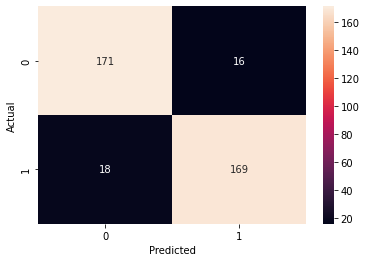

In [57]:
import seaborn as sns
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [58]:
from sklearn.metrics import accuracy_score
acc = np.round(accuracy_score(y_test, y_pred), 5)
acc

0.90909

### Predicting texts

In [59]:
predict_text = [
                # Spam
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest', 
                'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund', 
                'Your account is temporarily frozen. Please log in to to secure your account ', 
                '''We have a surprise for Kohl's users, start your day with our best rewards ''',
                #ham
                'The article was published on 18th August itself',
                'Thank you very much for your interest in Baker Tilly. Your resume will be reviewed by our recruiting staff and should we feel that your background meets our current needs we will make sure to get in touch with you soon.',
                'Thank you for reaching out. We are currently still interviewing other candidates at this time. Once a decision has been made, I’ll reach out to you with an update.'
]

In [60]:
test_results = model.predict(predict_text)
test_results

1/1 [==============================] - 4s 4s/step


array([[0.4891317 ],
       [0.9183947 ],
       [0.7930989 ],
       [0.5071753 ],
       [0.05922189],
       [0.40249914],
       [0.2719943 ]], dtype=float32)

In [61]:
output = np.where(test_results>0.5,'spam', 'ham')

In [62]:
output

array([['ham'],
       ['spam'],
       ['spam'],
       ['spam'],
       ['ham'],
       ['ham'],
       ['ham']], dtype='<U4')

## Method 2: Tokenizer

In [63]:
# Define tokenizing and padding parameters using vocab_size, max_length, embedding_dim, trunc_type='post', padding_type='post'
# oov_tok = "<OOV>", and training_size

vocab_size = 10000
embedding_dim = 8
max_length = 171
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"


In [65]:
from sklearn.model_selection import train_test_split

training_sentences, test_sentences, training_labels, test_labels  = train_test_split(df_balanced['Message'], df_balanced['spam'],
                                                                                     stratify = df_balanced['spam'])

print(len(training_sentences), len(test_sentences))

1120 374


In [66]:
training_sentences

2784                               K, wat s tht incident?
5004    Guess which pub im in? Im as happy as a pig in...
4875    lyricalladie(21/F) is inviting you to be her f...
3065    Get a brand new mobile phone by being an agent...
2810    Thinkin about someone is all good. No drugs fo...
                              ...                        
1023                             May i call You later Pls
1052    I got another job! The one at the hospital doi...
170     Sir, I need AXIS BANK account no and bank addr...
2806    December only! Had your mobile 11mths+? You ar...
2952    URGENT! Your mobile was awarded a Â£1,500 Bonu...
Name: Message, Length: 1120, dtype: object

In [67]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

X_train = tokenizer.texts_to_sequences(training_sentences)
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test = tokenizer.texts_to_sequences(test_sentences)
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [69]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 8)            80000     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                216       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 80,241
Trainable params: 80,241
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = model.fit(X_train_padded, training_labels,\
                    epochs = 30,
                    validation_data = (X_test_padded, test_labels))

Epoch 1/30
35/35 [==============================] - 1s 12ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.4973
Epoch 2/30
35/35 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.4973
Epoch 3/30
35/35 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5000 - val_loss: 0.6864 - val_accuracy: 0.5000
Epoch 4/30
35/35 [==============================] - 0s 6ms/step - loss: 0.6822 - accuracy: 0.5152 - val_loss: 0.6787 - val_accuracy: 0.5882
Epoch 5/30
35/35 [==============================] - 0s 5ms/step - loss: 0.6708 - accuracy: 0.7696 - val_loss: 0.6646 - val_accuracy: 0.7914
Epoch 6/30
35/35 [==============================] - 0s 5ms/step - loss: 0.6493 - accuracy: 0.8679 - val_loss: 0.6407 - val_accuracy: 0.8797
Epoch 7/30
35/35 [==============================] - 0s 6ms/step - loss: 0.6171 - accuracy: 0.8813 - val_loss: 0.6062 - val_accuracy: 0.9225
Epoch 8/30
35/35 [=

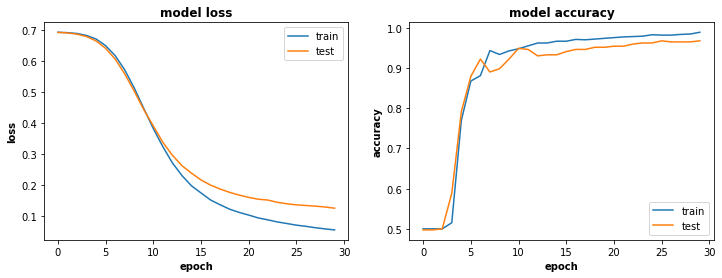

In [72]:
fig = plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', weight = 'bold')
plt.ylabel('loss', weight = 'bold')
plt.xlabel('epoch', weight = 'bold')
plt.legend(['train', 'test'], loc = 1)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy', weight = 'bold')
plt.ylabel('accuracy', weight = 'bold')
plt.xlabel('epoch', weight = 'bold')
plt.legend(['train', 'test'], loc = 4)
plt.show()

In [73]:
result = model.predict(X_test_padded)
result

12/12 [==============================] - 0s 2ms/step


array([[4.82793123e-01],
       [1.66756455e-02],
       [3.76065187e-02],
       [2.15011016e-02],
       [9.98148382e-01],
       [9.98221874e-01],
       [9.71082926e-01],
       [1.21023871e-01],
       [5.53553030e-02],
       [9.95789707e-01],
       [9.92006242e-01],
       [9.96340394e-01],
       [9.96850312e-01],
       [9.96715486e-01],
       [3.66687886e-02],
       [9.76062238e-01],
       [2.09887624e-02],
       [5.63654780e-01],
       [5.31588234e-02],
       [3.44888531e-02],
       [1.18040934e-01],
       [8.14117789e-02],
       [9.97214854e-01],
       [6.12206519e-01],
       [9.37264621e-01],
       [3.46914381e-02],
       [9.90766943e-01],
       [9.93493378e-01],
       [9.90693927e-01],
       [2.55690329e-02],
       [2.71428376e-01],
       [9.59463835e-01],
       [7.39506781e-02],
       [7.36899376e-02],
       [2.61883289e-01],
       [8.94805193e-01],
       [8.07312727e-02],
       [9.91265535e-01],
       [6.31393135e-01],
       [9.95029688e-01],


In [74]:
result=result > 0.5
result=result.flatten()
result

array([False, False, False, False,  True,  True,  True, False, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False, False, False, False,  True,  True,  True, False,  True,
        True,  True, False, False,  True, False, False, False,  True,
       False,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False,  True,  True, False,  True,  True,
       False, False, False,  True,  True, False, False,  True,  True,
        True, False, False,  True, False, False, False, False, False,
        True,  True, False, False, False,  True,  True,  True,  True,
       False,  True, False,  True,  True, False, False, False,  True,
       False,  True, False, False,  True,  True, False, False,  True,
        True, False,  True,  True, False, False,  True,  True,  True,
       False,  True, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [75]:
y_test

1042    0
567     0
2777    0
4625    0
2219    1
       ..
1780    1
3165    1
1903    1
877     1
1136    1
Name: spam, Length: 374, dtype: int64

In [76]:
from sklearn.metrics import confusion_matrix , classification_report

# creating confusion matrix 
cm = confusion_matrix(test_labels,result)
cm

array([[185,   2],
       [ 10, 177]])

Text(33.0, 0.5, 'Actual')

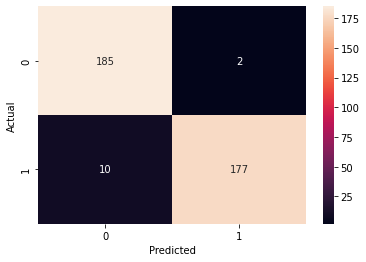

In [77]:
import seaborn as sns
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [78]:
from sklearn.metrics import accuracy_score
acc = np.round(accuracy_score(test_labels,result), 5)
acc

0.96791

In [79]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(predict_text)

predict_text = tokenizer.texts_to_sequences(predict_text)
predict_text = pad_sequences(predict_text, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [80]:
result = model.predict(predict_text)>0.5
result

1/1 [==============================] - 0s 23ms/step


array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

# Supplemenary Models

## Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth = 20, random_state = 0)

model.fit(X_train_padded, training_labels)

RandomForestClassifier(max_depth=20, random_state=0)

In [82]:
val = model.predict(X_test_padded)

acc = np.round(accuracy_score(test_labels, val), 5)

print("Accuracy on test set: " + str(acc))

Accuracy on test set: 0.86631


In [83]:
test_results = model.predict(predict_text)
test_results>0.5

array([ True,  True, False, False, False, False,  True])

### SVM (Support Vector Machine)

In [84]:
from sklearn.svm import SVC

model = SVC()

model.fit(X_train_padded, training_labels)

SVC()

In [85]:
val = model.predict(X_test_padded)

acc = np.round(accuracy_score(test_labels, val), 5)

print("Accuracy on test set: " + str(acc))

Accuracy on test set: 0.78075


In [86]:
test_results>0.5

array([ True,  True, False, False, False, False,  True])

### Decision Tree

In [87]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

model.fit(X_train_padded, training_labels)

DecisionTreeClassifier()

In [88]:
val = model.predict(X_test_padded)

acc = np.round(accuracy_score(test_labels, val), 5)

print("Accuracy on test set: " + str(acc))

Accuracy on test set: 0.75936
